### Bayesian optimization 

In [10]:
import scipy.optimize
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.preprocessing import OneHotEncoder
import sklearn
import GPy
import matplotlib.pyplot as plt

In [11]:
class Toy_function:
    '''
    This function is called Ackley, it's a standard benchmark function for optimizers.
    '''
    def __init__(self, ndim):
        self.ndim = ndim
        self.a = 20
        self.b = 0.2
        self.c = 2 * np.pi
        self.domain = [[-32.768, 32.768] for ii in range(self.ndim)]
        
    def f(self, X):
        if not isinstance(X, np.ndarray):
            raise TypeError("X have to be a 1D numpy array !")
        if X.ndim == 2 and X.shape[0] != 1:
            raise ValueError("Pass input values one by one")
        if X.ndim == 2:
            X = X.reshape(-1)
            
        if X.shape[0] != self.ndim:
            raise ValueError
        res = - self.a * np.exp(-self.b * np.sqrt((1/self.ndim) * np.sum(X**2))) - np.exp((1/self.ndim) * np.sum(np.cos(self.c * X))) + self.a + np.exp(1)
        return np.array(res).reshape(-1, 1)
          
function_to_optimize = Toy_function(ndim=2)
function_to_optimize.f(np.array([[0, 0]]).reshape(-1, 2))

array([[4.4408921e-16]])

### Random Initialization

In [14]:
## Code Here
# nb_init = 5
# function = Toy_function(ndim=2)
# f = function.f
# domain = function.domain

def draw_random(f, domain, nb_init=5):
    X_init = []
    for ii in range(nb_init):
        x = []
        for var_domain in domain:
            x.append(np.random.uniform(var_domain[0], var_domain[1]))
        X_init.append(x)
    X_init = np.array(X_init)
    Y_init = []
    for xx in X_init:
        Y_init.append(f(xx))
#    Y_init = f(X_init)
    Y_init = np.array(Y_init).reshape((-1, 1))
    return X_init, Y_init

func_class = Toy_function(ndim=2)
f = func_class.f
domain = func_class.domain
nb_init = 5
X_init, Y_init = draw_random(f, domain, nb_init)

#X_init, Y_init = draw_random_init(f, domain, nb_init)

### Create your surrogate model

In [15]:
## Code here
## See GPy GPRegression documentation
## Hint :
## - You need X, Y, kernel 
## - GP supports unnormalized data but can mislead the fitting process
## - A standard kernel for a smooth regression is Matern52, see GPy.kern.Matern52
## - You need to optimize hyper parameters and following the log marginal likelihood, see model.optimize 
class My_model:
    def __init__(self, input_dim, num_restarts_optim_model=10):
        self.standard_scaler_Y = sklearn.preprocessing.StandardScaler()
        self.standard_scaler_X = sklearn.preprocessing.StandardScaler()
        self.input_dim = input_dim
        self.model = None
        self.kernel = GPy.kern.Matern52(input_dim=self.input_dim)
        self.num_restarts = num_restarts_optim_model
    
    def fit(self, X, Y):
        self.standard_scaler_Y = self.standard_scaler_Y.fit(Y)
        self.standard_scaler_X = self.standard_scaler_X.fit(X)
        X_scaled = self.standard_scaler_X.transform(X)
        Y_scaled = self.standard_scaler_Y.transform(Y)
        self.model = GPy.models.GPRegression(X_scaled, Y_scaled, self.kernel)
        self.model.optimize_restarts(self.num_restarts, verbose=False)
    
    def predict(self, X):
        X_scaled = self.standard_scaler_X.transform(X)
        mu, sig = self.model.predict(X_scaled)
        return mu, sig
    
    def get_model(self):
        return self.model
    
    def get_kernel(self):

        return self.kernel

In [16]:
mymodel = My_model(input_dim=len(domain))
mymodel.fit(X_init, Y_init)
mymodel.get_model()

GP_regression.,value,constraints,priors
Mat52.variance,1.7104718844952183,+ve,
Mat52.lengthscale,2.66170713746036,+ve,
Gaussian_noise.variance,8.908542928997452e-10,+ve,


### Create your acqusition function

In [17]:
## Code here
## Minimization
class UCB_acquisition:
    def __init__(self, model, exploration_param=0.05):
        self.exploration = exploration_param
        self.model = model
    def acq(self, X):
        if X.ndim != 2:
            X = X.reshape(1, -1)
        mu, sigma = self.model.predict(X)
        return - mu - self.exploration * sigma

### Optimize your acquisition function

In [19]:
## Code here
def optimize_acquisition(acq, domain):
    
    # Setup f_to_optimize with a wrapper for convenience
    def f_wrapper(acq_obj):
        def f(X):
            return - acq_obj.acq(X).reshape(-1) # maximize <==> minimize the negative
        return f
    
    f_to_optim = f_wrapper(acq)
    
    # Scipy use local optimization ==> We need to introduce randomness
    nb_x0 = 5

    X_0 = []
    for ii in range(nb_x0):
        x = []
        for b in domain:
            x.append(np.random.uniform(b[0], b[1]))
        X_0.append(x)

    res = []
    for x0 in X_0:
        x0 = np.array(x0).reshape(1, -1)
       # print(str(x0) + "----" + str(model.predict(x0)) + "-----" + str(f_to_optim(x0)))
        r = scipy.optimize.minimize(f_to_optim, x0=x0, method="L-BFGS-B", bounds=domain)
        # we only want partial information 
        
        x_opt = r['x']
        f_acq_opt = r['fun']
        if r['status'] != 0:
            print("Something went wrong during acqusition optimization")
        res.append((x_opt, f_acq_opt))
    res.sort(key=lambda x:x[1])
    x_opt_final = res[0][0].reshape(1, -1)
    f_opt_final = - res[0][1]
    return x_opt_final, f_opt_final
        



acquisition = UCB_acquisition(mymodel, exploration_param = 0.05)
res = optimize_acquisition(acquisition, domain)

### All together : Bayesian optimization algorithm

In [8]:
## Code here
def bayesian_optimization(func, domain, budget=50):
    X_init, Y_init = draw_random_init(func, domain)
    X = X_init.copy()
    Y = Y_init.copy()
    
    for num_iter in range(budget):
        mymodel = My_model(input_dim=len(domain))
        mymodel.fit(X, Y)
        myacq = UCB_acquisition(mymodel)
        x_opt, f_acq_opt = optimize_acquisition(myacq, domain)
        new_y = func(x_opt)
        X = np.append(X, x_opt, axis=0)
        Y = np.append(Y, new_y, axis=0)
    return X, Y


function = Toy_function(ndim=2)
f = function.f
domain = function.domain

X, Y = bayesian_optimization(f, domain)

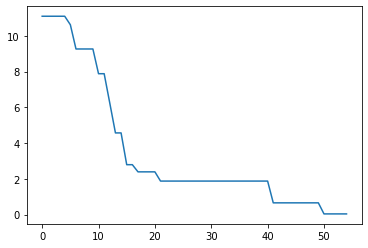

In [9]:
def plot_best_score_evolution(Y):
    best_y = []
    for yy in Y:
        if len(best_y) == 0:
            best_y.append(yy)
            continue
        if yy < best_y[len(best_y) - 1]:
            best_y.append(yy)
        else:
            best_y.append(best_y[len(best_y) - 1])
    
    plt.plot(best_y)
    plt.show()
plot_best_score_evolution(Y)

In [13]:
class Model_to_optimize():
    
    def __init__(self):
        self.list_names_param = [
            "min_samples_split",
            "min_samples_leaf",
            "min_weight_fraction_leaf",
            "max_features",
            "max_samples"]
        self.domain = [
            (10e-5, 1 - 10e-5), 
            (10e-5, 0.5),
            (10e-5, 0.5),
            (10e-5, 1 - 10e-5), 
            (10e-3, 1 - 10e-5) #--
        ]
        df = pd.read_csv("./laptop_price_clean.csv")
        X = df.drop(columns=['Price_euros'])
        self.X_data = pd.get_dummies(X)
        self.Y_data = np.log(df['Price_euros'])

    '''
        Parameters_array : numpy array containing 0+ values correspind to the parameters of the RF (if Ø or None, default values are used)
        Return: sklearn readable parameters
    '''
    def preprocess_input_parameters(self, parameters_array):
        self.params = {}
        for ii in range(parameters_array.shape[0]):
            if parameters_array[ii] is not None and (parameters_array[ii] < self.domain[ii][0] or parameters_array[ii] > self.domain[ii][1]):
                raise ValueError("parameter not in bound")
            if parameters_array[ii] is not None:
                self.params[self.list_names_param[ii]] = parameters_array[ii]

    def pipeline(self, X_data):
        pass
    
    def f(self, X):
        if not isinstance(X, np.ndarray):
            raise TypeError("X have to be a 1D numpy array !")
        if X.ndim == 2 and X.shape[0] != 1:
            raise ValueError("Pass input values one by one")
        if X.ndim == 2:
            X = X.reshape(-1)
            
        self.preprocess_input_parameters(X)
        kf = sklearn.model_selection.KFold(n_splits=5)
        res = []
        for train_index, test_index in kf.split(self.X_data):
            
            X_train = self.X_data.iloc[train_index]
            X_test = self.X_data.iloc[test_index]
            
            Y_train = self.Y_data.iloc[train_index]
            Y_test = self.Y_data.iloc[test_index]
            
            model = ensemble.RandomForestRegressor(**self.params)
            model.fit(X_train, Y_train)
            Y_pred = model.predict(X_test)
            try:
                metric = sklearn.metrics.r2_score(Y_test, Y_pred)
                res.append(metric)
            except ValueError:
                print(self.params)

        score = np.mean(res) #- np.std(res) 
        # Maximize (mean(R2 score) - std(R2 score)) <==> Minimize it's negative
        return np.array( - score).reshape(-1, 1)


In [19]:
model_to_optimize = Model_to_optimize()
domain = model_to_optimize.domain

X, Y = bayesian_optimization(model_to_optimize.f, domain)

Something went wrong during acqusition optimization


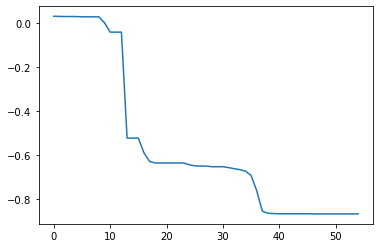

In [20]:
plot_best_score_evolution(Y)